In [1]:
import pynbody
import glob

import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../util/')
from util import util

## Get Our Galaxies

In [2]:
currentGals = util.getGalaxies()[0]

## Lookback Time and Redshift

In [4]:
gal = currentGals[1]
cdmFile = util.getfilepath(gal)[0]+ '/r'+str(gal)+'.romulus25.3072g1HsbBH.004096'

# tmp 
#cdmFile = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r468.romulus25.3072g1HsbBH/'
#cdmFile += 'r468.romulus25.3072g1HsbBH.003936/r468.romulus25.3072g1HsbBH.003936'

sCDM = pynbody.load(cdmFile)
sCDM.physical_units()

vdisp = sCDM.g['v_disp']

hCDM = sCDM.halos(write_fpos=False)[1]

pynbody.analysis.angmom.faceon(hCDM)

cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
sCDM['pos'] -= cen_pot

In [6]:
#sCDM.properties['boxsize'] = 2.5e4

In [7]:
sCDM.properties['boxsize']

Unit("2.50e+04 kpc")

In [8]:
pynbody.analysis.cosmology.age(sCDM)

13.800820457603765

## Half Mass Radius (Stellar Mass)

Call the function twice for an accurate measurement. First with coarse steps and low accuracy and then again with finer steps and accuracy using 90% of the first measurement as a starting point

In [4]:
# input: a simulation 
# output: half mass radius of that simulation
def halfMassRadius(sim, startR, incBy, acc):
    pRadii = np.array(sim.s['r'])
    pMass = np.array(sim.s['mass'])
    mTot = sum(pMass)
    
    # start at 5 kpc and increment
    r = startR-incBy
    hm = mTot
    while(hm < (0.50-acc)*mTot or hm > (0.5+acc)*mTot):
        r += incBy
        hm = sum(pMass[pRadii < r])
        
        if (r>max(pRadii)):
            return -1
        
    return r

In [5]:
halfMassRadius(sCDM, 0, 1, 0.1)

3

In [9]:
halfMassRadius(sCDM,2,0.05,0.01)

2.849999999999997

In [6]:
def halfMassRadius_bisect(sim, outerR, acc):
    innerLim = 0.0
    outerLim = outerR
    guessR = 0.0

    pRadii = np.array(sim.s['r'])
    pMass = np.array(sim.s['mass'])
    mTot = sum(pMass)

    r = outerR
    hm = mTot
    while(hm < (0.50-acc)*mTot or hm > (0.5+acc)*mTot):
        if hm > 0.5*mTot:
            outerLim = r
            r = innerLim + (outerLim-innerLim)/2
        if hm < 0.5*mTot:
            innerLim = r
            r = innerLim + (outerLim-innerLim)/2
        hm = sum(pMass[pRadii < r])

    return r

In [12]:
halfMassRadius_bisect(sCDM,100,0.001)

2.9052734375

In [16]:
sCDM.s['vel']

SimArray([[  65.63792589,   13.30896193,  -43.46616412],
          [  14.4127238 ,   -5.42542935,  -21.1465444 ],
          [  30.21906607,    5.52502769,   16.57051852],
          ...,
          [-107.88541766,    8.87287087,    7.71992681],
          [ -21.97960799,  -86.69778089,   -4.84913249],
          [ -22.97036113,  -78.56799526,   -2.0968231 ]], 'km s**-1')

## Manual V disp 

In [60]:
def compute_vdisp(velocities, masses):
    center_of_mass_velocity = np.sum(velocities * masses[:, None], axis=0) / np.sum(masses)
    velocity_differences = velocities - center_of_mass_velocity
    velocity_differences_squared = np.sum(velocity_differences**2, axis=1)
    mass_weighted_dispersion = np.sqrt(np.sum(velocity_differences_squared * masses) / np.sum(masses))
    #return mass_weighted_dispersion
    return velocity_differences

In [55]:
mask = sCDM.s['age'].in_units('Myr')<10
compute_vdisp(sCDM.s['vel'][mask], sCDM.s['mass'][mask])

SimArray(66.98288933, 'km s**-1')

### V disp of cold gas (T < 1000K)

In [14]:
coldgasVel = sCDM.g['vel']
coldgasMass= sCDM.g['mass']

mask = sCDM.g['temp']<=1000

coldgasVel = coldgasVel[mask]
coldgasMass= coldgasMass[mask]

compute_vdisp(coldgasVel, coldgasMass)

SimArray(57.04085245, 'km s**-1')

In [7]:
sCDM.g['temp'][sCDM.g['temp']<=1000]

SimArray([212.44827271, 428.86395264, 957.68774414, ...,  38.43917084,
           38.46290588,  38.44889832], 'K')

## v disp as std dev of radial velocity

In [144]:
# desired params 
gal = currentGals[15]
tsidx = 0

# get to sim file 
baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
galDir = baseDir + '/r' + str(gal)+'.romulus25.3072g1HsbBH'

timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
timesteps.sort(reverse=True)

tsnum = timesteps[tsidx][-4:]
simfile = glob.glob(timesteps[tsidx]+'/r'+str(gal)+'*.00'+tsnum)

# load simfile 
sCDM = pynbody.load(simfile[0])
sCDM.physical_units()

# center 
hCDM = -1
try:
    hCDM = sCDM.halos(write_fpos=False)[1]
except:
    # center manually if missing halo; taken from pynbody source code
    #print('HNF for halo ' + str(gal) + ', timestep '+str(tstepnumber))
    i = sCDM['phi'].argmin()
    cen_pot = sCDM['pos'][i].copy()
    sCDM['pos'] -= cen_pot
else:
    hCDM = sCDM.halos(write_fpos=False)[1]
    cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
    sCDM['pos'] -= cen_pot

36.61407101860485


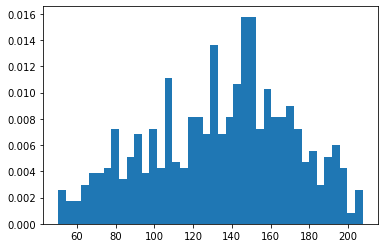

In [145]:
mask = sCDM.s['age'].in_units('Myr')<10
vr = np.linalg.norm(sCDM.s['vel'][mask], axis=1)
plt.hist(vr, density=True, bins=40);
print(np.std(vr))

## Mass weighted vdisp as a func of radius vs pynbody vdisp as a func of radius

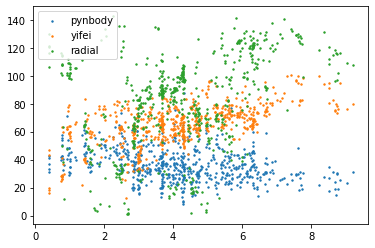

In [96]:
mask = sCDM.s['age'].in_units('Myr')<10

positions = sCDM.s['pos'][mask]
velocities = sCDM.s['vel'][mask]
masses = sCDM.s['mass'][mask]
rads = sCDM.s['r'][mask]

vdisp_p = sCDM.s['v_disp'][mask]
vdisp_m = np.linalg.norm(compute_vdisp(velocities, masses), axis=1)
vdisp_r = abs(sCDM.s['vr'][mask])

plt.scatter(rads, vdisp_p, s=2)
plt.scatter(rads, vdisp_m, s=2)
plt.scatter(rads, vdisp_r, s=2)

plt.legend(['pynbody', 'yifei', 'radial'])

In [98]:
np.std(vdisp_r)

SimArray(31.83992167, 'km s**-1')

In [89]:
np.median(vdisp_p)

SimArray(34.92601009, 'km s**-1')

In [110]:
np.std(vdisp_m)

14.128832969094422

## sigma_gas
From Hirtenstein (2019): HII regions within 100 PC of young stars (10MYR); calculate density weghted dispersion. Median over 100 lines of sight 

In [15]:
sCDM.all_keys()

['HII',
 'HeIII',
 'ne',
 'hetot',
 'hydrogen',
 'feh',
 'oxh',
 'ofe',
 'mgfe',
 'nefe',
 'sife',
 'c_s',
 'c_s_turb',
 'mjeans',
 'mjeans_turb',
 'ljeans',
 'ljeans_turb',
 'r',
 'rxy',
 'vr',
 'v2',
 'vt',
 'ke',
 'te',
 'j',
 'j2',
 'jz',
 'vrxy',
 'vcxy',
 'vphi',
 'vtheta',
 'v_mean',
 'v_disp',
 'v_curl',
 'vorticity',
 'v_div',
 'age',
 'u_mag',
 'u_lum_den',
 'b_mag',
 'b_lum_den',
 'v_mag',
 'v_lum_den',
 'r_mag',
 'r_lum_den',
 'i_mag',
 'i_lum_den',
 'j_mag',
 'j_lum_den',
 'h_mag',
 'h_lum_den',
 'k_mag',
 'k_lum_den',
 'U_mag',
 'U_lum_den',
 'B_mag',
 'B_lum_den',
 'V_mag',
 'V_lum_den',
 'R_mag',
 'R_lum_den',
 'I_mag',
 'I_lum_den',
 'J_mag',
 'J_lum_den',
 'H_mag',
 'H_lum_den',
 'K_mag',
 'K_lum_den',
 'theta',
 'alt',
 'az',
 'cs',
 'mu',
 'p',
 'u',
 'temp',
 'zeldovich_offset',
 'aform',
 'tform',
 'iord_argsort',
 'smooth',
 'rho',
 'den',
 'vel',
 'H2',
 'smoothlength',
 'phi',
 'HI',
 'igasorder',
 'massHot',
 'c',
 'tempEff',
 'OxMassFrac',
 'u',
 'FeMassFrac'

In [9]:
sCDM['H2']

SimArray([5.e-13, 5.e-13, 5.e-13, ..., 0.e+00, 0.e+00, 0.e+00],
         dtype=float32)

In [10]:
sCDM['pos']

SimArray([[ 1.64062444e+03, -1.74213870e+03, -1.65957617e+03],
          [ 4.42786370e+02, -1.02821935e+03, -1.35912648e+03],
          [ 6.19598084e+02, -1.04668156e+03, -8.57752596e+02],
          ...,
          [-1.60686801e+00,  8.04683085e+00, -9.32106562e-01],
          [-8.96595639e+00,  2.03968476e+00, -6.31504702e-01],
          [-9.64827340e+00,  1.61920923e+00,  3.14472328e-01]], 'kpc')

In [11]:
len(sCDM.s['pos'][sCDM.s['age'].in_units('Myr')<10])

2772

In [12]:
youngstarPos = sCDM.s['pos'][sCDM.s['age'].in_units('Myr')<10]
HIIpos = sCDM.g['pos']

In [13]:
pynbody.snapshot.tipsy.HII(sCDM.g)

SimArray([ 7.63956096e-01,  7.63957387e-01,  7.63991614e-01, ...,
          -1.73698522e-09,  5.29173979e-01, -1.57068238e-08])

KeyboardInterrupt: 

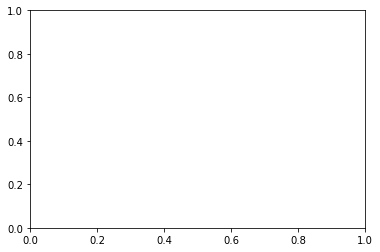

In [14]:
# contour to find HII regions
x = sCDM.g['pos'][:,0]
y = sCDM.g['pos'][:,1]
z = sCDM.g['pos'][:,2]

poslim = 1000

hii = sCDM.g['HII'][abs(x)<poslim]
z = z[abs(x)<poslim]
y = y[abs(x)<poslim]
x = x[abs(x)<poslim]

hii = hii[abs(y)<poslim]
z = z[abs(y)<poslim]
x = x[abs(y)<poslim]
y = y[abs(y)<poslim]

hii = hii[abs(z)<poslim]
x = x[abs(z)<poslim]
y = y[abs(z)<poslim]
z = z[abs(z)<poslim]

trc = plt.tricontour(x,y,hii)
plt.colorbar()

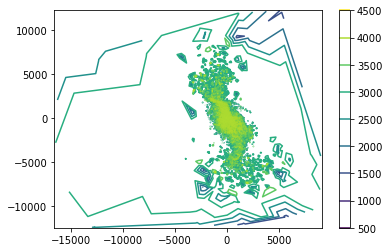

In [47]:
# contour gas mass 
x = sCDM.g['pos'][:,0]
y = sCDM.g['pos'][:,1]
z = sCDM.g['pos'][:,2]

gmass = sCDM.g['mass']

plt.tricontour(x,y,gmass)
plt.colorbar()

Text(0.5, 0, 'Number of HII Ions Per Proton Mass')

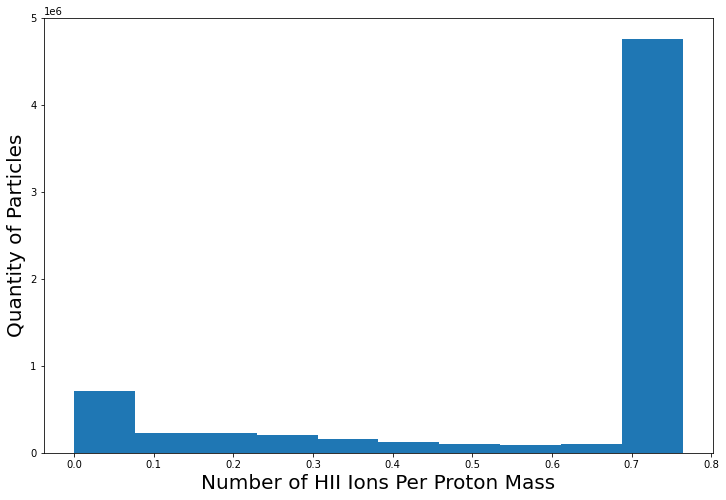

In [27]:
fig = plt.figure(facecolor='w', figsize=(12,8))

hs = plt.hist(sCDM.g['HII'], density=False, stacked=True)
plt.ylabel('Quantity of Particles', fontsize=20)
plt.xlabel('Number of HII Ions Per Proton Mass', fontsize=20)

In [37]:
len(sCDM.g['pos'])

6013100

In [38]:
gal = currentGals[0]
cdmFile = util.getfilepath(gal)[0]+ '/r'+str(gal)+'.romulus25.3072g1HsbBH.004096'

sCDM = pynbody.load(cdmFile)
sCDM.physical_units()

vdisp = sCDM.g['v_disp']

hCDM = sCDM.halos(write_fpos=False)[1]

pynbody.analysis.angmom.faceon(hCDM)

cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
sCDM['pos'] -= cen_pot

In [45]:
# want HII particles near stars

# take regions that are mostly HII 
HIIpos = sCDM.g['pos'].in_units('pc')

selectedHIIdisps = []
allHIIdisps = sCDM.g['vr']

# want regions within 100 pc of young (10 MYR) stars
youngStarPos = sCDM.s['pos'].in_units('pc')[sCDM.s['age'].in_units('Myr')<10]
for i,hii in enumerate(HIIpos[:]):
    distances = abs(youngStarPos - hii)
    distances = np.linalg.norm(distances, axis=1)
    
    # if close to a young star, calculate v disp for that particle
    if min(distances)<100:
        selectedHIIdisps.append(allHIIdisps[i])
    if i%500000==0: print(i)

0
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000


In [47]:
len(selectedHIIdisps)

142419

In [49]:
np.median(np.abs(selectedHIIdisps))

11.452646856604877

In [51]:
np.median(vdisp)

SimArray(22.85070953, 'km s**-1')

In [5]:
# above didn't provide any particles
# let's just directly take v disp of HII dominated particles


hiimask = sCDM.g['HII']>0.75

In [14]:
gal = currentGals[1]
#cdmFile = util.getfilepath(gal)[0]+ '/r'+str(gal)+'.romulus25.3072g1HsbBH.004096'
cdmFile='/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r468.romulus25.3072g1HsbBH/'
cdmFile+='r468.romulus25.3072g1HsbBH.003936/r468.romulus25.3072g1HsbBH.003936'

sCDM = pynbody.load(cdmFile)
sCDM.physical_units()
hCDM = sCDM.halos(write_fpos=False)[1]

pynbody.analysis.angmom.faceon(hCDM)

cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
sCDM['pos'] -= cen_pot

hiimask = sCDM.g['HII']>0.75

RuntimeError: No halo catalogue found for '<SimSnap "/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r468.romulus25.3072g1HsbBH/r468.romulus25.3072g1HsbBH.003936/r468.romulus25.3072g1HsbBH.003936" len=25789729>'

In [10]:
sCDM.g['HII']

KeyError: "'metals' is a family-level array for [<Family gas>, <Family star>]. To use it over the whole simulation you need either to delete it first, or create it separately for [<Family dm>]."

(array([5.070e+02, 2.464e+03, 3.221e+03, 2.221e+03, 1.209e+03, 3.160e+02,
        4.000e+01, 1.300e+01, 8.000e+00, 1.000e+00]),
 array([-23.11633993,  -2.56619697,  17.98394599,  38.53408895,
         59.08423192,  79.63437488, 100.18451784, 120.7346608 ,
        141.28480376, 161.83494672, 182.38508968]),
 <BarContainer object of 10 artists>)

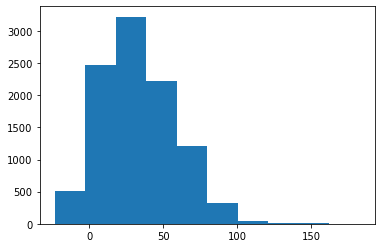

In [69]:
plt.hist(sCDM.g['vr'][:10000])

## Need to Navigate the Folders of Emu

* Given a halo number
* navigate to each sim file and open it
* acquire desired categories

In [58]:
sCDM.s['age'].in_units('Myr')

SimArray([1.35277645e+03, 1.34268115e+03, 1.34183987e+03, ...,
          6.40484514e-03, 6.40484514e-03, 6.40484514e-03], 'Myr')

In [35]:
np.log10(sum(sCDM.g['mass']))

10.267842295296536

In [29]:
sCDM.all_keys()

['HII',
 'HeIII',
 'ne',
 'hetot',
 'hydrogen',
 'feh',
 'oxh',
 'ofe',
 'mgfe',
 'nefe',
 'sife',
 'c_s',
 'c_s_turb',
 'mjeans',
 'mjeans_turb',
 'ljeans',
 'ljeans_turb',
 'r',
 'rxy',
 'vr',
 'v2',
 'vt',
 'ke',
 'te',
 'j',
 'j2',
 'jz',
 'vrxy',
 'vcxy',
 'vphi',
 'vtheta',
 'v_mean',
 'v_disp',
 'v_curl',
 'vorticity',
 'v_div',
 'age',
 'u_mag',
 'u_lum_den',
 'b_mag',
 'b_lum_den',
 'v_mag',
 'v_lum_den',
 'r_mag',
 'r_lum_den',
 'i_mag',
 'i_lum_den',
 'j_mag',
 'j_lum_den',
 'h_mag',
 'h_lum_den',
 'k_mag',
 'k_lum_den',
 'U_mag',
 'U_lum_den',
 'B_mag',
 'B_lum_den',
 'V_mag',
 'V_lum_den',
 'R_mag',
 'R_lum_den',
 'I_mag',
 'I_lum_den',
 'J_mag',
 'J_lum_den',
 'H_mag',
 'H_lum_den',
 'K_mag',
 'K_lum_den',
 'theta',
 'alt',
 'az',
 'cs',
 'mu',
 'p',
 'u',
 'temp',
 'zeldovich_offset',
 'aform',
 'tform',
 'iord_argsort',
 'smooth',
 'rho',
 'eps',
 'phi',
 'pos',
 'mass',
 'vel']

In [27]:
def makeGalQtyCSV(gal, startTS=0, export=True):
    baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
    galDir = baseDir+ '/r' + str(gal)+'.romulus25.3072g1HsbBH'

    timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
    timesteps.sort(reverse=True)
    
    if export:
        # setup file for exporting values
        outfile = '/home/jw1624/H1-merian/csvs/breathingModes/r'+str(gal)+'_qtys.txt'
        if startTS == 0:
            fout = open(outfile,'w')
            fout.write('galaxyID,timestep,t,z,')
            fout.write('M_star,R_halflight,R_halfmass,')
            fout.write('sigma_gas,sigma_star,')
            fout.write('SFR_10,SFR_100,sSFR_10,sSFR_100\n')
            fout.close()
    
    # iterate through each timestep
    for timestep in timesteps[startTS:]:
        print(timestep)
        if export: fout = open(outfile, 'a')
        tstepnumber = timestep[-6:]

        # I'm assuming that if there's another subfolder, the sim is inside it

        # try to find sim file in current folder
        simFile = timestep+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
        # check if there's another folder
        a=glob.glob(timestep+'/*')
        if len(a)>0:
            # find sim in folder
            simFile = timestep+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
            #simFile+= '/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
            print(glob.glob(simFile)) 
            
        #print(glob.glob(simFile))
        # handle sim file not existing
        if len(glob.glob(simFile)) == 0:
            print('FNF for halo ' + str(gal) + ', timestep '+tstepnumber)
            continue

        # open simfile 
        sCDM = pynbody.load(simFile)

        sCDM.physical_units()
        
        # SFR and sSFR (do first otherwise we sometimes get an error)
        SFR_10  = sum(sCDM.s['mass'][sCDM.s['age'].in_units('Myr')<10])
        SFR_100 = sum(sCDM.s['mass'][sCDM.s['age'].in_units('Myr')<100])
        
        hCDM = -1
        try:
            hCDM = sCDM.halos(write_fpos=False)[1]
        except:
            # center manually if missing halo; taken from pynbody source code
            #print('HNF for halo ' + str(gal) + ', timestep '+str(tstepnumber))
            i = sCDM['phi'].argmin()
            cen_pot = sCDM['pos'][i].copy()
            sCDM['pos'] -= cen_pot
        else:
            hCDM = sCDM.halos(write_fpos=False)[1]
            cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
            sCDM['pos'] -= cen_pot
            
            pynbody.analysis.angmom.faceon(hCDM)

        # get age of universe
        uage = pynbody.analysis.cosmology.age(sCDM)
        # get redshift
        stepZ = pynbody.analysis.cosmology.redshift(sCDM, uage)

        # Mass
        mStar = sum(sCDM.s['mass'])

        # Sizes
        #rVir = pynbody.analysis.halo.virial_radius(sCDM)
        rHL = pynbody.analysis.luminosity.half_light_r(sCDM)

        rHM = halfMassRadius(sCDM, 0, 1, 0.1)
        rHM = halfMassRadius(sCDM,rHM*0.85, 0.05, 0.01)

        # velocity dispersion
        sCDM.properties['boxsize'] = 3.0e4
        sigma_gas = np.median(sCDM.g['v_disp'])
        sigma_star= np.median(sCDM.s['v_disp'])

        # sSFR
        sSFR_10 = SFR_10/mStar
        sSFR_100 = SFR_100/mStar

        if export:
            # write to file
            fout.write(str(gal)+','+str(tstepnumber)+','+str(uage)+','+str(stepZ)+',')
            #fout.write(str(mStar)+','+str(rVir)+','+str(rHL)+','+str(rHM)+',')
            fout.write(str(mStar)+','+str(rHL)+','+str(rHM)+',')
            fout.write(str(sigma_gas)+','+str(sigma_star)+',')
            fout.write(str(SFR_10)+','+str(SFR_100)+','+str(sSFR_10)+','+str(sSFR_100)+'\n')

            fout.close()
        print('r'+str(gal)+' '+str(tstepnumber)+' done')

In [28]:
makeGalQtyCSV(568, export=False)

/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r568.romulus25.3072g1HsbBH/r568.romulus25.3072g1HsbBH.004096
['/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r568.romulus25.3072g1HsbBH/r568.romulus25.3072g1HsbBH.004096/r568.romulus25.3072g1HsbBH.004096']


NameError: name 'halfMassRadius' is not defined

In [ ]:
for gal in currentGals[1:]:
    makeGalQtyCSV(gal)

r468 000069 done
r468 000096 done
r468 000105 done
r468 000136 done
r468 000186 done
r468 000192 done
r468 000223 done
r468 000273 done
r468 000288 done
r468 000345 done
r468 000384 done
r468 000454 done
r468 000480 done
r468 000576 done
r468 000635 done
r468 000672 done
r468 000768 done
r468 000775 done
r468 000864 done
r468 000960 done
r468 000972 done
r468 001056 done
r468 001104 done
r468 001152 done
r468 001248 done
r468 001268 done
r468 001344 done
r468 001440 done
r468 001474 done
r468 001536 done
r468 001632 done
r468 001728 done
r468 001739 done
r468 001824 done
r468 001920 done


## Single Timestep Investigating

In [3]:
gal = currentGals[0]

baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
galDir = baseDir+ '/r' + str(gal)+'.romulus25.3072g1HsbBH'

timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
timesteps.sort(reverse=True)
timesteps

['/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.004096',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.004032',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003936',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003840',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003744',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003648',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003606',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003552',
 '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms/r431.romulus25.3072g1HsbBH/r431.romulus25.3072g1HsbBH.003456',
 '/data/RE

In [19]:
timestep = timesteps[-13]
tstepnumber = timestep[-6:]

# try to find sim file in current folder
simFile = timestep+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
# check if there's another folder
a=glob.glob(timestep+'/*/*')
if len(a)>0:
    # find sim in folder
    simFile = timestep+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
    simFile+= '/r'+str(gal)+'.romulus25.3072g1HsbBH.'+tstepnumber
    #print(glob.glob(simFile)) 

#print(glob.glob(simFile))
# handle sim file not existing
if len(glob.glob(simFile)) == 0:
    print('FNF for halo ' + str(gal) + ', timestep '+tstepnumber)

# open simfile 
sCDM = pynbody.load(simFile)

sCDM.physical_units()

# SFR and sSFR (do first otherwise we sometimes get an error)
SFR_10  = sum(sCDM.s['mass'][sCDM.s['age'].in_units('Myr')<10])
SFR_100 = sum(sCDM.s['mass'][sCDM.s['age'].in_units('Myr')<100])

hCDM = -1

/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/snapshot/tipsy.py:124: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  warnings.warn(


In [20]:
hCDM = -1
try:
    hCDM = sCDM.halos(write_fpos=False)[1]
except:
    # center manually if missing halo; taken from pynbody source code
    #print('HNF for halo ' + str(gal) + ', timestep '+str(tstepnumber))
    print('doing manual centering')
    i = sCDM['phi'].argmin()
    cen_pot = sCDM['pos'][i].copy()
    sCDM['pos'] -= cen_pot
else:
    hCDM = sCDM.halos(write_fpos=False)[1]
    cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
    sCDM['pos'] -= cen_pot

    pynbody.analysis.angmom.faceon(hCDM)

doing manual centering


In [22]:
# get age of universe
uage = pynbody.analysis.cosmology.age(sCDM)
# get redshift
stepZ = pynbody.analysis.cosmology.redshift(sCDM, uage)

# Mass
mStar = sum(sCDM.s['mass'])

# Sizes
#rVir = pynbody.analysis.halo.virial_radius(sCDM)
rHL = pynbody.analysis.luminosity.half_light_r(sCDM)

/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'a'=1.00e+00
  warnings.warn("Assuming default value for property '{}'={:.2e}".format(
/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'h'=6.78e-01
  warnings.warn("Assuming default value for property '{}'={:.2e}".format(
/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaM0'=3.09e-01
  warnings.warn("Assuming default value for property '{}'={:.2e}".format(
/home/jw1624/miniconda3/lib/python3.9/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaL0'=6.91e-01
  warnings.warn("Assuming default value for property '{}'={:.2e}".format(


In [23]:
rHL

SimArray(0.34249912, 'kpc')

In [24]:
tstepnumber

'001152'

In [26]:
uage

13.795660358777317

## Morphology

In [3]:
currentGals

array([431, 442, 468, 492, 502, 515, 523, 556, 568, 569, 571, 597, 613,
       615, 618, 634])

In [42]:
gal = currentGals[0]
tsidx = 0
R = 6

baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
galDir = baseDir+ '/r' + str(gal)+'.romulus25.3072g1HsbBH'

timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
timesteps.sort(reverse=True)

tsnum = timesteps[tsidx][-4:]
tsfile = glob.glob(timesteps[tsidx]+'/r*.00'+tsnum)[0]

sCDM = pynbody.load(tsfile)
sCDM.physical_units()

hCDM = sCDM.halos(write_fpos=False)[1]
cen_pot = pynbody.analysis.halo.center(hCDM, mode='pot', retcen=True)
sCDM['pos'] -= cen_pot

rbin, ba, ca, angle, es = pynbody.analysis.halo.halo_shape(sCDM, rout=1.1*R, N=1, rin = 1*R)

In [43]:
rbin[-1]

6.29766649502923

In [44]:
ba[-1]

0.966829532681573

In [45]:
ca[-1]

0.5544317600532499

(array([2.71407619e-04, 2.14286856e-05, 7.66519145e-06, 3.89188949e-05,
        2.12487322e-05, 1.23132540e-05, 6.22960451e-06, 4.41423260e-06,
        5.05536305e-07, 1.39871705e-08]),
 array([    0.        ,  2603.17869713,  5206.35739426,  7809.53609139,
        10412.71478851, 13015.89348564, 15619.07218277, 18222.2508799 ,
        20825.42957703, 23428.60827416, 26031.78697129]),
 <BarContainer object of 10 artists>)

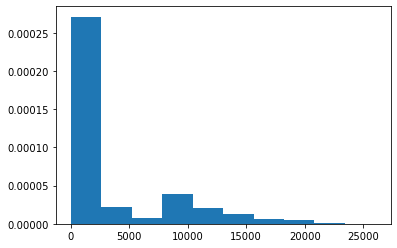

In [24]:
radii = np.linalg.norm(sCDM['pos'], axis=1)
plt.hist(radii, density=True)

In [25]:
sCDM['pos']

SimArray([[-2.77027935e+03, -2.57217325e+01, -8.97652283e+02],
          [-1.74130201e+03,  2.56881490e+02,  4.89775091e+01],
          [-1.46816969e+03, -1.15299784e+02, -2.15330720e+02],
          ...,
          [ 5.36199659e+00,  6.28018752e+00,  1.02818012e-01],
          [ 3.50195915e+00,  1.87512487e+00,  8.31671059e+00],
          [ 4.03784215e+00,  9.03941691e-01,  8.87066126e+00]], 'kpc')

# Bridge

In [42]:
def halfMassRadius_bisect(positions, masses, outerR, acc, maxiter=100000):
    innerLim = 0.0
    outerLim = outerR

    pRadii = np.linalg.norm(positions, ord=2, axis=1)
    mTot = sum(masses)

    r = outerR/2
    hm = sum(masses[pRadii < r])
    n=0
    while(hm < (0.50-acc)*mTot or hm > (0.5+acc)*mTot):
        if hm > 0.5*mTot: # too big, decrease r
            outerLim = r
            r = innerLim + (outerLim-innerLim)/2
        elif hm < 0.5*mTot: # too small, increase r
            innerLim = r
            r = innerLim + (outerLim-innerLim)/2
        hm = sum(masses[pRadii < r])

        n += 1
        if n>maxiter:
            return -1
            break

    return r

In [109]:
gal = 442
ts0 = 0
ts1 = 1

# these apply to both snapshots 
baseDir = '/data/REPOSITORY/e11Gals/romulus_dwarf_zooms'
galDir = baseDir+ '/r' + str(gal)+'.romulus25.3072g1HsbBH'
timesteps = glob.glob(galDir+'/r*.romulus25.3072g1HsbBH.0*')
timesteps.sort(reverse=True)

# load ts0
simfile0 = timesteps[ts0]+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+timesteps[ts0][-6:]
a=glob.glob(timesteps[ts0]+'/*')
if len(a)>0:
    # find sim in folder
    simfile0 = timesteps[ts0]+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+timesteps[ts0][-6:]

sZero = pynbody.load(simfile0)
sZero.physical_units()

# load ts1
simfile1 = timesteps[ts1]+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+timesteps[ts1][-6:]
a=glob.glob(timesteps[ts1]+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+timesteps[ts1][-6:])
if len(a)>0:
    # find sim in folder
    #simfile1 = simfile1+'/r'+str(gal)+'.romulus25.3072g1HsbBH.'+timesteps[ts1][-6:]
    _
    
sOne = pynbody.load(simfile1)
sOne.physical_units()

In [110]:
sZero.s['pos']

SimArray([[-636.24638132,  174.51832536, -616.63910745],
          [-636.53611577,  176.35169206, -618.32019127],
          [-638.60313966,  175.10524485, -618.85965987],
          ...,
          [-639.18600789,  176.22412415, -621.74755147],
          [-635.79380511,  178.08632692, -620.0802978 ],
          [-635.80628483,  178.08233387, -619.92402187]], 'kpc')

In [111]:
sOne.s['pos']

SimArray([[-629.55118551,  169.72856554, -607.21191865],
          [-625.4120823 ,  168.33629505, -603.66945037],
          [-625.52924404,  168.72949104, -602.19446937],
          ...,
          [-625.14394981,  170.69691605, -604.32429918],
          [-625.44034057,  170.75996962, -603.92996781],
          [-625.43561557,  170.76687363, -603.95028991]], 'kpc')

In [112]:
hZero = sZero.halos()[1]
haloCen = pynbody.analysis.halo.center(hZero, mode='pot', retcen=True)

Rhm0 = halfMassRadius_bisect(hZero.s['pos']-haloCen, hZero.s['mass'], 1000, 0.01)

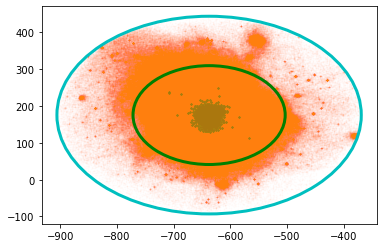

In [113]:
# testing how well we capture the galaxy in snapshot 0
fig, ax = plt.subplots(1,1)

rfac = 50
dfac = 2.0
galmask = np.linalg.norm(sZero.s['pos'].in_units('kpc') - haloCen, axis=1)<rfac*Rhm0
dmmask = np.linalg.norm(sZero.d['pos'].in_units('kpc') - haloCen, axis=1)<dfac*rfac*Rhm0

plt.scatter(sZero.s['pos'][:,0][galmask], sZero.s['pos'][:,1][galmask], s=1)
plt.scatter(sZero.d['pos'][:,0][dmmask], sZero.d['pos'][:,1][dmmask], s=1, alpha = 0.01)

c1 = plt.Circle((haloCen[0],haloCen[1]), rfac*Rhm0, edgecolor='g', linewidth=3, fill=False)
c2 = plt.Circle((haloCen[0],haloCen[1]), dfac*rfac*Rhm0, edgecolor='c', linewidth=3, fill=False)

ax.add_patch(c1)
ax.add_patch(c2)

(-5000.0, 3000.0)

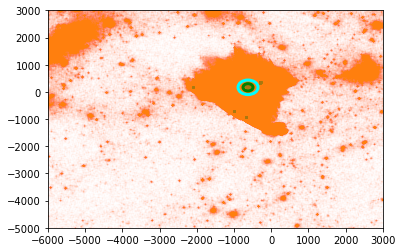

In [117]:
# testing how well this translates to the next snapshot
fig, ax = plt.subplots(1,1)

mtot = sOne.s['mass'].sum()
oneCen = np.sum(sOne.s['mass'] * sOne.s['pos'].transpose(),
             axis=1) / mtot
oneCen.units = sOne.s['pos'].units

plt.scatter(sOne.s['pos'][:,0], sOne.s['pos'][:,1], s=1)
plt.scatter(sOne.d['pos'][:,0], sOne.d['pos'][:,1], s=1, alpha = 0.01)

c1 = plt.Circle((oneCen[0],oneCen[1]), rfac*Rhm0, edgecolor='g', linewidth=3, fill=False)
c2 = plt.Circle((oneCen[0],oneCen[1]), dfac*rfac*Rhm0, edgecolor='cyan', linewidth=3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)

ax.set_xlim([-2000,2000])
ax.set_ylim([-1000,1000])

In [119]:
starmask = np.linalg.norm(sOne.s['pos']-oneCen, axis=1)<rfac*Rhm0
np.log10(sum(sOne.s['mass'][starmask]))

9.154227692161886